<a href="https://www.kaggle.com/code/julioam/instagram-reach-analysis-exploration?scriptVersionId=163103700" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [65]:
import numpy as np
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [47]:
#import data
df = pd.read_csv('../input/instagram-reach/instagram_reach.csv')

In [48]:
#head of data
df.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,2,3,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,3,4,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,4,5,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [49]:
#check info of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         100 non-null    int64 
 1   S.No               100 non-null    int64 
 2   USERNAME           100 non-null    object
 3   Caption            94 non-null     object
 4   Followers          100 non-null    int64 
 5   Hashtags           100 non-null    object
 6   Time since posted  100 non-null    object
 7   Likes              100 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 6.4+ KB
None


There are missing values on Caption column

# Data Cleaning

## Remove unnecessary column

In [50]:
#because there is only 6 main features (columns), "Unnamed:0" and "S.No" columns will removed
df.drop(['Unnamed: 0','S.No'], inplace=True,axis=1)

## Dealing with missing values

In [51]:
#only Caption column that has missing values so missing values will be dropped
df.dropna(inplace=True)

## Change data type & column name

In [52]:
#change column name 
df.rename(columns={'USERNAME':'Username'}, inplace=True)

#change time since posted into hours
time_since_posted_in_hours=[]
for i in df['Time since posted']:
    time_since_posted_in_hours.append(i.replace('hours', ''))
se = pd.Series(time_since_posted_in_hours)
df['Time since posted (hours)'] = se.values
df['Time since posted (hours)'] = pd.to_numeric(df['Time since posted (hours)'])
df = df.drop('Time since posted', axis=1)
    
#change caption, username, hashtag into string
df[['Username', 'Caption','Hashtags']].astype(str, copy=False)   

,Username,Caption,Hashtags
0,mikequindazzi,Who are #DataScientist and what do they do? >>...,#MachineLearning #AI #DataAnalytics #DataScien...
1,drgorillapaints,We all know where it’s going. We just have to ...,#deck .#mac #macintosh#sayhello #apple #steve...
2,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,#whoiswho #aitrading #ai #aitradingteam#instat...
3,opensourcedworkplace,sfad,#iot #cre#workplace #CDO #bigdata #technology#...
4,crea.vision,Ever missed a call while your phone was chargi...,#instamachinelearning #instabigdata#instamarke...
...,...,...,...
95,michaelgarza__,"328 S. Wetherly Drive, Beverly Hills, CA 90212...",#beverlyhills #realestate#losangelesrealestate...
96,dvlp_search,Credit @tristankappel To find more dvlp follow...,#workspace #work #developer#development #devel...
97,ecom.space,We are coming up with the Best 21 Books that w...,#books #book #motivation #inspiration #life#bo...
98,lb3enterprises,We’re only paid to move dirt once. It’s not ju...,#heavyequipment #underconstruction#dozer #real...


In [53]:
#check new data
df.head()

,Username,Caption,Followers,Hashtags,Likes,Time since posted (hours)
0,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,139,11
1,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,23,2
2,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,25,2
3,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,49,3
4,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,30,3


# Exploratory Data Analysis

In [66]:
#Distribution of followers 
fig = px.box(df, x='Followers', title='Distribution of followers')
fig.show()

Most of the account has under 1.5k followers

In [67]:
#Distribution of followers 
fig = px.box(df, x='Likes', title='Distribution of likes')
fig.show()

Most of the posts have under 50 likes

In [68]:
#Distribution of followers 
fig = px.box(df, x='Time since posted (hours)', title='Distribution of followers')
fig.show()

Most of the posts posted less then 5 hours ago

In [56]:
print(f"There are {df['Username'].nunique()} unique users")

There are 90 unique users


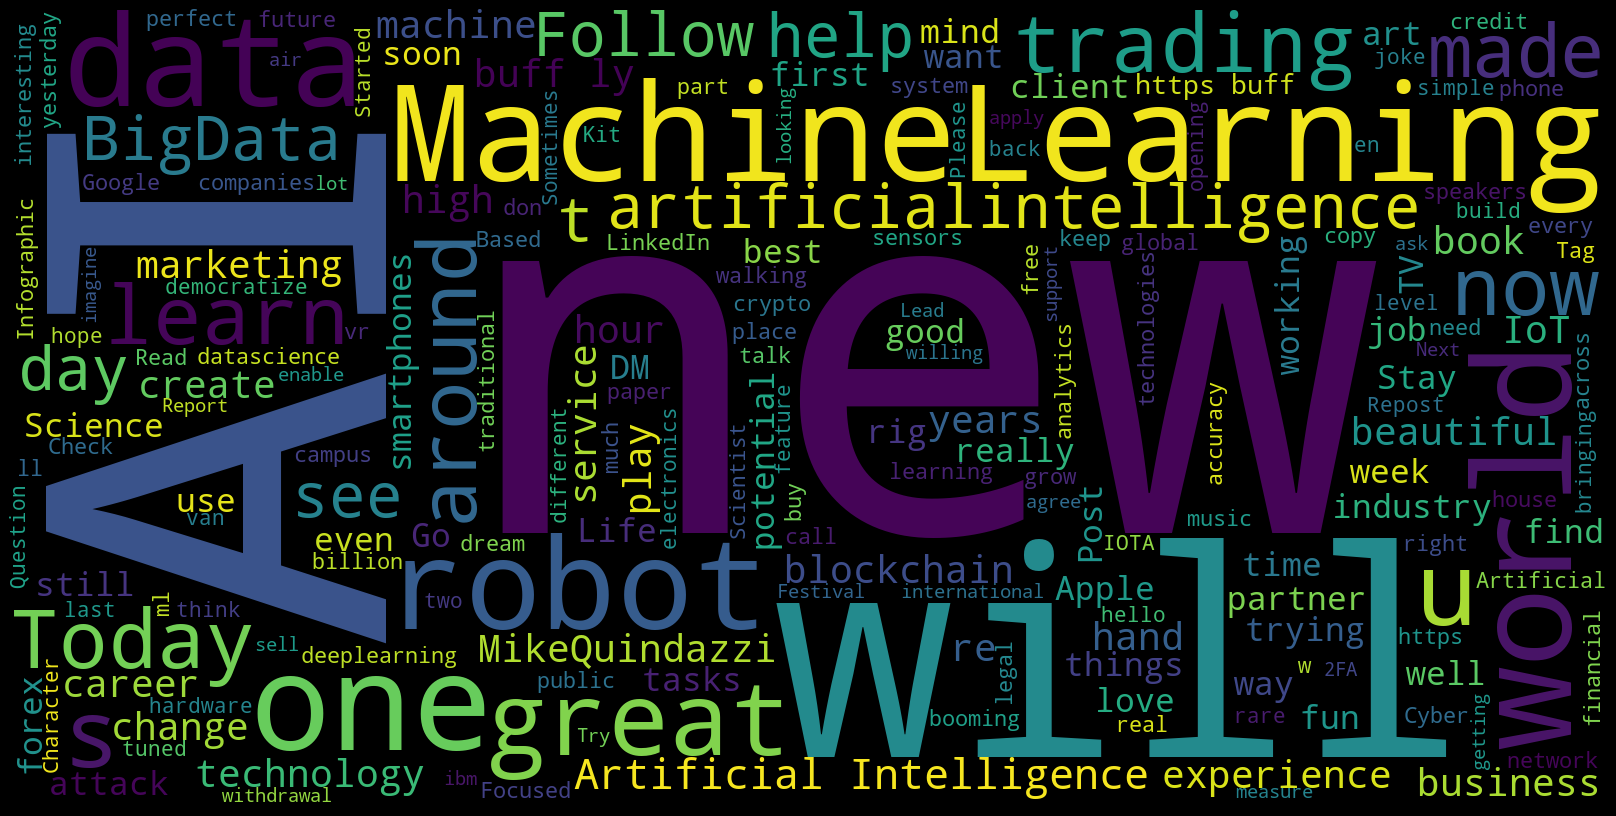

In [57]:
#caption wordcloud
text = " ".join(i for i in df.Caption)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800).generate(text)
plt.style.use('classic')
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

From wordcloud above we know that words like 'AI', 'will', 'new' are the top three words on caption

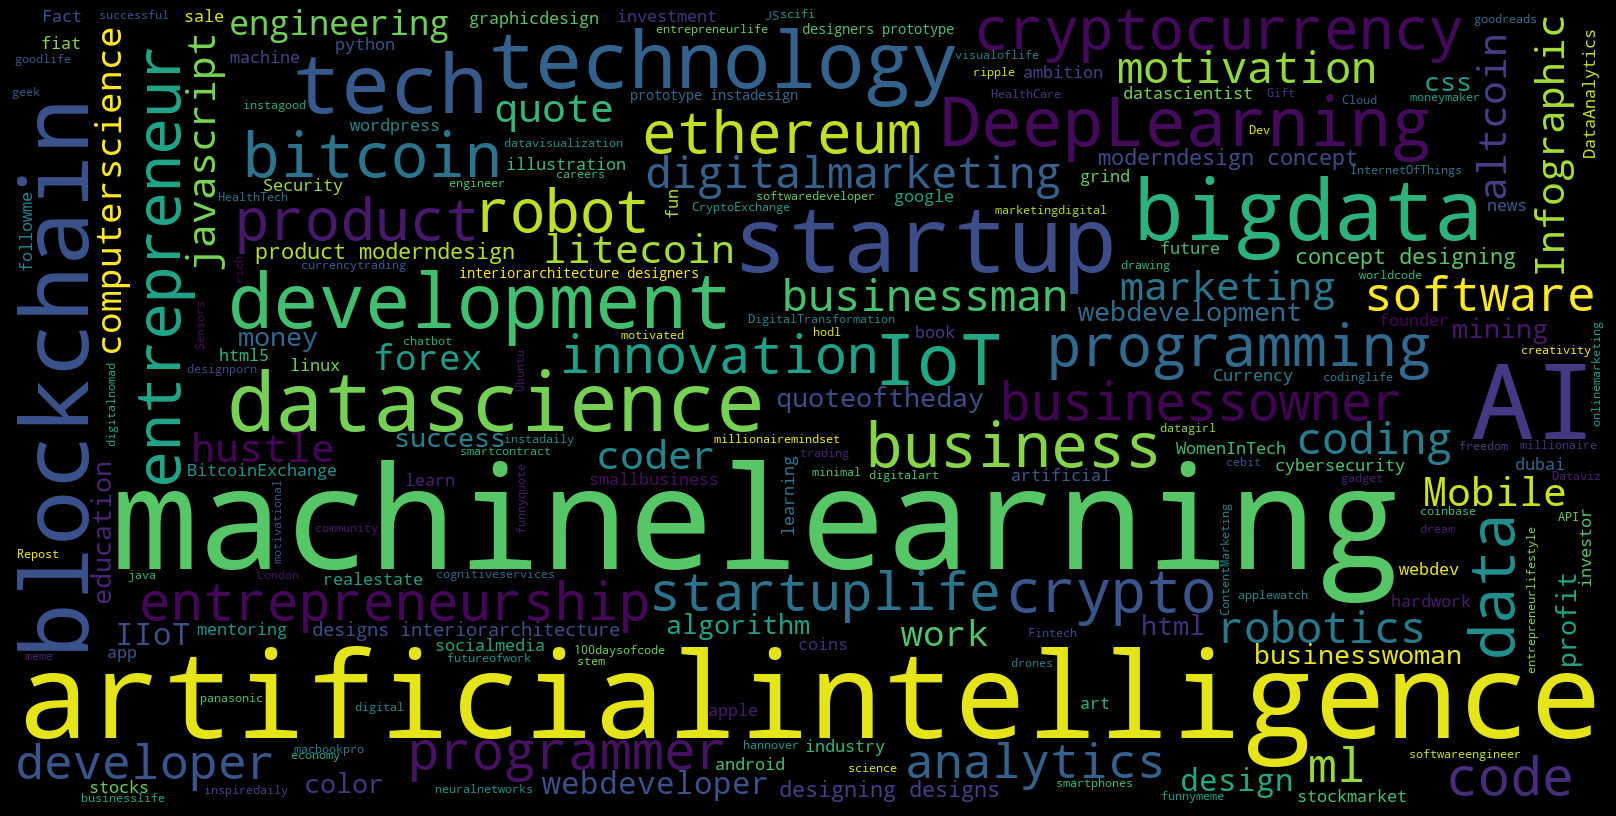

In [58]:
#hashtags wordcloud
text = " ".join(i for i in df.Hashtags)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=1600, height=800).generate(text)
#plt.style.use('classic')
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

From wordcloud above we know that words like 'artificialintelligence', 'machinelearning', 'AI' are the top three words on hashtags

## Relationship between two variables

In [59]:
fig = px.scatter(df, x='Time since posted (hours)', y='Likes', 
                 title='Likes vs Time since posted')
fig.show()

There is a linear relationship between likes and time since posted even though most of data shows no relationship

In [60]:
fig = px.scatter(df, x='Followers', y='Likes', 
                 title='Likes vs Followes')
fig.show()

There is a linear relationship between these two variables. The relationship is positive on some data and negative on some data

In [63]:
fig = px.imshow(df[['Followers', 'Likes', 'Time since posted (hours)']].corr(), text_auto=True)
fig.show()

- There is a weak positive correlation between likes and followers
- There is a weak positive correlation between likes and time since posted
- There is a strong positive relationship between time since posted and likes

## Modelling

In [74]:
#Standardizing

Predicting reach with XGBRegressor

In [69]:
#Define x variables and y variable
#x = df[['Followers', 'Time since posted (hours)']]
#y = df['Likes']

#Split train set and test set
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [70]:
#Fit the model and predict the value of test set
#model = XGBRegressor()
#model.fit(X_train, y_train)

#Define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#Evaluate the model
#scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#Absolute MAE
#scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 18.272 (8.974)


The XGBoost model achieved a mean MAE of 18.272 and MAE std of 8.974

Using linear regression

In [71]:
#lin_reg = LinearRegression()
#lin_reg.fit(X_train, y_train)

#Define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#Evaluate the model
#scores = cross_val_score(lin_reg, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#Absolute MAE
#scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 17.737 (11.099)


The Linear Regression model achieved a mean MAE of 17.737 and MAE std of 11.099

In [72]:
#check coefficient of determination of linear regression model
#r_sq = lin_reg.score(x, y)
#print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.3814063866179843


Linear Regression model has smaller mean of MAE than XGBoost model but has low R Square

In [73]:
#Predict new likes using XGBoost
#X_new = np.array([[240, 7]])
#model.predict(X_new)

array([0.13489202], dtype=float32)

Summary

This is how you can analyze and predict the likes of Instagram posts with machine learning using Python. With this notebook, we could know the example of Data Science role in social media. I hope you could give feedback and advice to this notebook. Thank you.

References : 

https://thecleverprogrammer.com/2022/03/22/instagram-reach-analysis-using-python/
https://machinelearningmastery.com/xgboost-for-regression/